# ISLR-Python: Applied 10

- [A. Generate Simulated Data](#A.-Generate-Simulated-Data)
- [B. Split Data into Train and Test Sets](#B.-Split-Data-into-Train-and-Test-Sets)
- [C. Perform Best Subset Selection](#C.-Perform-Best-Subset-Selection)
- [D. Plot Test MSE](#D.-Plot-Test-MSE)
- [E. Comment on Results](#E.-Comment-on-Results)
- [F. Compare Best Subset Model to True Model](#F.-Compare-Best-Subset-Model-to-True-Model)

In [22]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

from tqdm import tqdm
from operator import itemgetter
from itertools import combinations

from sklearn.preprocessing import PolynomialFeatures

from matplotlib import pyplot as plt

%matplotlib inline
plt.style.use('ggplot') # emulate R's pretty plotting

# print numpy arrays with precision 4
np.set_printoptions(precision=4)

## A. Generate Simulated Data

In [140]:
np.random.seed(0)

# Create a normal random vector
X = np.random.randn(1000,1)

# create set of 12 coeffecients + 1 intercept. The interept and first three coeffecients will be non-zero
# Note the book ask for 20 features but this takes a bit long to run. 12 works just fine to demonstrate the
# same result the book is aiming for.
betas=np.zeros((13,))
np.put(betas,[0,1,2,3],[2, 4, 3, 1])

# generate a noise term
eps = np.random.randn(1000,1)

# create response
Y = betas[0]+betas[1]*X + betas[1]*X + betas[2]*X**2 + betas[3]*X**3 + eps

# Create a design matrix
poly = PolynomialFeatures(degree=12, include_bias=False)
X_arr = poly.fit_transform(X)

# create a dataframe of features and responses
# make some names for the columns in our dataframe
col_names = ['Y']+['X_' + str(i) for i in range(1,len(betas))]
# make dataframe
df = pd.DataFrame(np.concatenate((Y,X_arr), axis=1), columns=col_names)
df.head()

,Y,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12
0,31.493544,1.764052,3.111881,5.489520,9.683801,17.082733,30.134834,53.159425,93.776009,165.425788,291.819750,514.785315,908.108242
1,6.638184,0.400157,0.160126,0.064075,0.025640,0.010260,0.004106,0.001643,0.000657,0.000263,0.000105,0.000042,0.000017
2,13.218934,0.978738,0.957928,0.937561,0.917626,0.898116,0.879020,0.860330,0.842038,0.824134,0.806612,0.789461,0.772676
3,46.349541,2.240893,5.021602,11.252875,25.216490,56.507461,126.627185,283.757997,635.871366,1424.919820,3193.093133,7155.380687,16034.443920
4,34.145454,1.867558,3.487773,6.513618,12.164559,22.718020,42.427220,79.235294,147.976506,276.354706,516.108440,963.862441,1800.069003


## B. Split Data into Train and Test Sets

In [105]:
train_df = df.sample(n=100, random_state=0)
test_df = df.drop(train_df.index)
print('Training Set Size:', len(train_df), '\nTesting Set Size:', len(test_df))

Training Set Size: 100 
Testing Set Size: 900


## C. Perform Best Subset Selection

On my to do list is to make a class that performs best subset, forward and backwards selection. It's not done yet, so fo now I'm copying the best subsets function I wrote in the lab.

In [106]:
def best_subsets(dataframe, predictors, response, max_features=8):
    """
    Regresses response onto subsets of the predictors in dataframe. Compares models with equal feature 
    numbers choosing the one with the lowest RSS as the 'best' model for that number of features.
    
    PARAMETERS
    ----------
    dataframe : pandas dataframe obj containing responses and predictors
    predictors : list of column names of dataframe used as features
    response : list of column name of dataframe used as target
    
    RETURNS
    -------
    a list of best models, one per feature number
    
    ex.
    [best 1 feat model, best two feat model] = best_subsets(df, predictors, response, max_features = 2)
    """
    
    def process_linear_model(features):
        """
        Constructs Linear Model Regression of response onto features.
        """
        # Create design Matrix
        X = sm.add_constant(dataframe[features])
        y = dataframe[response]

        model = sm.OLS(y,X).fit()
        RSS = model.ssr
        return (model, RSS)

    def get_best_kth_model(k):
        """
        Returns the model from all models with k-predictors with the lowest RSS.
        """
        results = []

        for combo in combinations(predictors, k):
            # process linear model with this combo of features
            results.append(process_linear_model(list(combo)))

        # sort the models and return the one with the smallest RSS
        return sorted(results, key= itemgetter(1)).pop(0)[0]
    
    models =[]
    for k in tqdm(range(1,max_features+1)):
        models.append(get_best_kth_model(k))
    
    return models

In [120]:
features = list(train_df.columns[1:])
models = best_subsets(train_df, features, ['Y'], max_features=12)

100%|██████████| 12/12 [00:07<00:00,  1.56it/s]


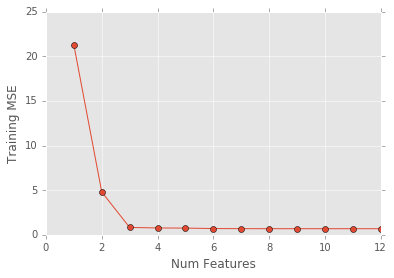

In [121]:
# now for each of the models we will Plot the training MSE
mses = np.array([])
for model in models:
    # get the predictors for this model, ignore constant
    features = list(model.params.index[1:])
    
    # get the corresponding columns of df_test
    X_train = sm.add_constant(train_df[features])
    
    # make prediction for this model
    y_predicted = model.predict(X_train)
    
    # get the MSE for this model
    mses = np.append(mses, np.mean((y_predicted - train_df.Y.values)**2))

    
fig, ax = plt.subplots(figsize=(6,4));
ax.plot(range(1,len(features)+1), mses, marker='o');
ax.set_xlabel('Num Features');
ax.set_ylabel('Training MSE');

## D. Plot Test MSE

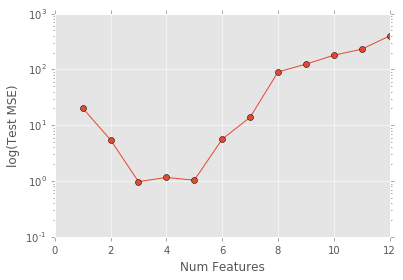

In [138]:
mses = np.array([])
for model in models:
    # get the predictors for this model, ignore constant
    features = list(model.params.index[1:])
    
    # get the corresponding columns of df_test
    X_test = sm.add_constant(test_df[features])
    
    # make prediction for this model
    y_predicted = model.predict(X_test)
    
    # get the MSE for this model
    mses = np.append(mses, np.mean((y_predicted - test_df.Y.values)**2))

    
fig, ax = plt.subplots(figsize=(6,4));
ax.plot(range(1,len(features)+1),mses, marker='o');
ax.set_xlabel('Num Features');
ax.set_ylabel('log(Test MSE)');
ax.set_yscale('log')

## E. Comment on Results

The best model occurs for three features. On this dataset the test error increases sharply as the number of features increases. With 20 features, the model has very high variance and since we use only 1/10 of the total samples for training we end up with a model that fits the test data very poorly. 

## F. Compare Best Subset Model to True Model

In [137]:
# The best three feature model has the following coeffecients
models[2].params

const    1.956810
X_1      8.139257
X_2      2.970160
X_3      0.963357
dtype: float64

The values of the coeffecients are similar to the simulated values of [2,4,3,1] except for the X_1 feature.

In [126]:
coeff_norms =[]
for idx, model in enumerate(models):
    # get the models betas and pad them with zeros so they are always len(models)
    model_betas = np.pad(model.params.values[1:],(0,len(models)-idx), 'constant', constant_values=[0])
    # compute the l2 norm of the coeffecients-model(coeffecients)
    coeff_norms.append(np.sqrt(np.sum((betas-model_betas)**2)))

12


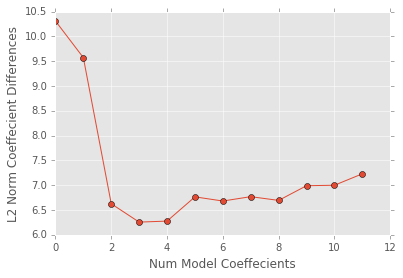

In [139]:
fig, ax = plt.subplots()
ax.plot(coeff_norms,marker='o');
ax.set_ylabel('L2 Norm Coeffecient Differences');
ax.set_xlabel('Num Model Coeffecients');

So the L2 norm of the coeffecient differences is a scaled version of the TEST MSE curve. As we increase the number of coeffecients, the L2 norm of the difference will increase. This again is reflecting that the varaince of the model increases with increasing parameters... Increasing variance increases the difference in the L2 norm difference of the true beta and the models betas.